## Cluster Analysis

In [54]:
# Clustering test script for short static task

import csv
import pandas as pd
import numpy as np
import scipy as sp
import statistics
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from statsmodels.stats import weightstats as stests
from kneed import KneeLocator
from sklearn.metrics import silhouette_samples, silhouette_score
pd.set_option('display.max_rows', 2000)

### Setup

In [55]:
# Raw data filename
shortpath = Path(r"C:/Users/bbio/Documents/GrazianoLab/4-Correlates_of_Social_Cognition/shortened_static_awareness_task/data")
fn1 = "SSAT_070820_203subs.xlsx"
fn2 = "SSAT_RMET_HT_5.xlsx"

# Import data csv
df1_raw = pd.read_excel(shortpath / fn1,sheet_name="data",usecols="A:IF")
df2_raw = pd.read_excel(shortpath / fn2,sheet_name="SSAT",usecols="A:IF")
rmet1_raw = pd.read_excel(shortpath / fn1,sheet_name="rmet")
rmet2_raw = pd.read_excel(shortpath / fn2,sheet_name="RMET")

# Copy raw data to manipulate
df_temp = pd.concat([df1_raw,df2_raw],axis=0)
rmet_temp = pd.concat([rmet1_raw,rmet2_raw],axis=0)
combined = pd.concat([df_temp,rmet_temp],axis=1)

# NA counts
na_list = combined.isna().sum(axis=1)
na_raw = pd.DataFrame(na_list)
na_raw.columns = ["NAs"]

combined = pd.concat([combined,na_raw],axis=1)
combined = combined.reset_index(drop=True)

In [56]:
combined.head(10)

,chalk_AAC,wine_ATC,door_HAI,tsunami_ATC,sinkhole_AAC,building_HTI,carcrash_HAI,hurricane_HTI,spider_ATC,rottenorange_AAC,...,violin_HTC,gift_HTC,gift_HAC,flowers_ATI,tree_AAI,rose_AAI,sunbeam_HTC,sunbeam_HAC,rmet,NAs
0,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,...,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,8,8
1,Very Aware,Very Aware,Not Aware,Very Aware,Not Aware,Somewhat Aware,Not Aware,Somewhat Aware,Very Aware,Somewhat Aware,...,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,32,2
2,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Somewhat Aware,Not Aware,NaN,Very Aware,Somewhat Aware,...,Very Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,30,9
3,Somewhat Aware,Not Aware,NaN,NaN,Not Aware,Very Aware,NaN,NaN,Somewhat Aware,NaN,...,NaN,Very Aware,Very Aware,Not Aware,NaN,Not Aware,Very Aware,Very Aware,15,41
4,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Very Aware,Not Aware,Very Aware,Very Aware,Not Aware,...,Very Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Not Aware,Not Aware,34,4
5,Not Aware,NaN,NaN,NaN,NaN,Somewhat Aware,Not Aware,Very Aware,Somewhat Aware,NaN,...,Very Aware,Very Aware,Not Aware,NaN,NaN,Not Aware,Somewhat Aware,Not Aware,21,36
6,Not Aware,Somewhat Aware,NaN,Somewhat Aware,Not Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Not Aware,...,Very Aware,Very Aware,NaN,NaN,Not Aware,NaN,Very Aware,Not Aware,23,57
7,Somewhat Aware,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Not Aware,...,NaN,Somewhat Aware,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,12,13
8,Not Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,...,Very Aware,Very Aware,Not Aware,Not Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware,24,2
9,Somewhat Aware,Somewhat Aware,Not Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Somewhat Aware,...,Very Aware,Very Aware,Not Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware,20,4


In [57]:
# Create subject list
subs = []

# Count subs
subCount = len(combined.index)

for x in range(1,subCount + 1):
    if x < 10:
        tmp = "s00" + str(x)
    elif 9 < x < 100:
        tmp = "s0" + str(x)
    elif x > 99: 
        tmp = "s" + str(x)
    subs.append(tmp)

# Add column with subject names
combined.insert(loc=0, column='sub', value=subs)
na_raw.insert(loc=0, column='sub', value=subs)

In [58]:
#nadf[nadf.NAs > 47]
combined.shape

(831, 243)

In [59]:
# drop subs under 80% performance
#thresh80 = combined.dropna(thresh=192)
thresh80 = combined.dropna(thresh=195)

# Replace df with thresholded subs
ssat = thresh80.iloc[:,0:241]

# Reset indices (row names) to make up for dropped subs
df = ssat.reset_index(drop=True)

# Subset to match # of HT done
#df = df[:300]

# Pull out rmet from joint df
rmet = thresh80[['rmet']]

# Subset to match # of HT done
#rmet = rmet[:300]

# Reset indices (row names) to make up for dropped subs
rmet = rmet.reset_index(drop=True)

In [60]:
na2_list = thresh80.isna().sum(axis=1)
nadf = pd.DataFrame(na2_list)
nadf.columns = ["NAs"]

In [61]:
df.tail(10)

,sub,chalk_AAC,wine_ATC,door_HAI,tsunami_ATC,sinkhole_AAC,building_HTI,carcrash_HAI,hurricane_HTI,spider_ATC,...,fries_HAC,scooter_HTC,violin_HTC,gift_HTC,gift_HAC,flowers_ATI,tree_AAI,rose_AAI,sunbeam_HTC,sunbeam_HAC
669,s820,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,...,Somewhat Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Somewhat Aware,Not Aware,Somewhat Aware,Very Aware,Somewhat Aware
670,s822,Somewhat Aware,Very Aware,Very Aware,Very Aware,Somewhat Aware,Very Aware,Very Aware,Very Aware,Very Aware,...,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware,Very Aware
671,s823,Very Aware,Very Aware,Not Aware,Very Aware,Very Aware,Not Aware,Not Aware,Not Aware,NaN,...,Somewhat Aware,Somewhat Aware,Very Aware,Very Aware,Very Aware,Not Aware,Not Aware,Not Aware,Very Aware,Very Aware
672,s824,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,Very Aware,Very Aware,...,Somewhat Aware,Very Aware,Very Aware,Somewhat Aware,Very Aware,Very Aware,Somewhat Aware,Very Aware,Very Aware,Very Aware
673,s826,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,...,Not Aware,Somewhat Aware,Very Aware,Somewhat Aware,Not Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware
674,s827,Not Aware,NaN,Not Aware,NaN,Not Aware,Somewhat Aware,NaN,Very Aware,Very Aware,...,Not Aware,Very Aware,Very Aware,Somewhat Aware,Not Aware,Somewhat Aware,Not Aware,Not Aware,Very Aware,Not Aware
675,s828,Somewhat Aware,Very Aware,Not Aware,Very Aware,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,...,Somewhat Aware,Very Aware,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Not Aware,Not Aware,Very Aware,Somewhat Aware
676,s829,Very Aware,Very Aware,Not Aware,Very Aware,Very Aware,Not Aware,Not Aware,Not Aware,Very Aware,...,Not Aware,Not Aware,Not Aware,Not Aware,Not Aware,Somewhat Aware,Somewhat Aware,Very Aware,Not Aware,Not Aware
677,s830,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Somewhat Aware,NaN,...,Very Aware,Very Aware,Somewhat Aware,Somewhat Aware,Very Aware,Somewhat Aware,Very Aware,Very Aware,NaN,Somewhat Aware
678,s831,NaN,Very Aware,NaN,Somewhat Aware,Not Aware,Not Aware,Not Aware,Very Aware,Very Aware,...,NaN,Very Aware,Very Aware,Very Aware,Not Aware,Very Aware,Very Aware,NaN,Not Aware,Somewhat Aware


In [62]:
# Subset data into fine grain categories
AAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAC")]],axis=1)
AAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_AAI")]],axis=1)
AHN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAI")]],axis=1)
AHP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HAC")]],axis=1)
TAN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATC")]],axis=1)
TAP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_ATI")]],axis=1)
THN = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTI")]],axis=1)
THP = pd.concat([df.iloc[:,0:1],df.loc[:,df.columns.str.contains("_HTC")]],axis=1)

# Subset data into 4 main categories & create long-form versions of dfs
GNegENeg = pd.merge(AAP, AHN, on='sub')
GNegENeg.insert(loc=1, column='cond', value='GNegENeg')
GNegENeg_melted = pd.melt(GNegENeg,('sub','cond'),var_name='trial',value_name='rating')
GNegEPos = pd.merge(AAN, AHP, on='sub')
GNegEPos.insert(loc=1, column='cond', value='GNegEPos')
GNegEPos_melted = pd.melt(GNegEPos,('sub','cond'),var_name='trial',value_name='rating')
GPosENeg = pd.merge(TAP, THN, on='sub')
GPosENeg.insert(loc=1, column='cond', value='GPosENeg')
GPosENeg_melted = pd.melt(GPosENeg,('sub','cond'),var_name='trial',value_name='rating')
GPosEPos = pd.merge(TAN, THP, on='sub')
GPosEPos.insert(loc=1, column='cond', value='GPosEPos')
GPosEPos_melted = pd.melt(GPosEPos,('sub','cond'),var_name='trial',value_name='rating')

# Combine all conditions into one dataframe to plot
AllConds = pd.concat([GNegENeg_melted,GNegEPos_melted,GPosENeg_melted,GPosEPos_melted])

# Create numerical value dataframe
GnEn = GNegENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEp = GNegEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEn = GPosENeg.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GpEp = GPosEPos.replace({'Not Aware':-1,'Somewhat Aware':0,'Very Aware':1})
GnEn_sums = GnEn.sum(axis=1)
GnEp_sums = GnEp.sum(axis=1)
GpEn_sums = GpEn.sum(axis=1)
GpEp_sums = GpEp.sum(axis=1)

condSums = pd.DataFrame(columns=['GnEn', 'GnEp', 'GpEn', 'GpEp'])
subNum = len(df.index)

for n in range(1,subNum + 1):
    rowNum = n - 1
    a = GnEn_sums.iloc[rowNum]
    b = GnEp_sums.iloc[rowNum]
    c = GpEn_sums.iloc[rowNum]
    d = GpEp_sums.iloc[rowNum]
    condSums = condSums.append({'GnEn': a, 'GnEp': b, 'GpEn': c, 'GpEp': d}, ignore_index=True)

scs  = condSums/100

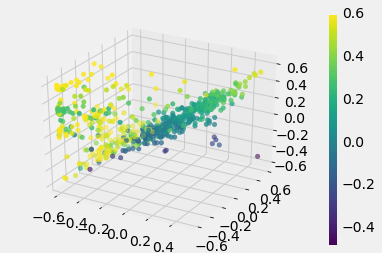

In [63]:
# 4D plot of conds
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = scs["GnEn"]
y = scs["GnEp"]
z = scs["GpEn"]
c = scs["GpEp"]

img = ax.scatter(x, y, z, c=c, cmap=plt.viridis())
fig.colorbar(img)
plt.show()

In [64]:
#wcss = []
#for i in range(1, 11):
#    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#    kmeans.fit(scs)
#    wcss.append(kmeans.inertia_)
#plt.plot(range(1, 11), wcss)
#plt.title('Elbow Method')
#plt.xlabel('Number of clusters')
#plt.ylabel('WCSS')
#plt.show()

In [65]:
kmeans_kwargs = {
   ...:     "init": "random",
   ...:     "n_init": 10,
   ...:     "max_iter": 300,
   ...:     "random_state": 42,
   ...: }
   ...:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scs)
    sse.append(kmeans.inertia_)

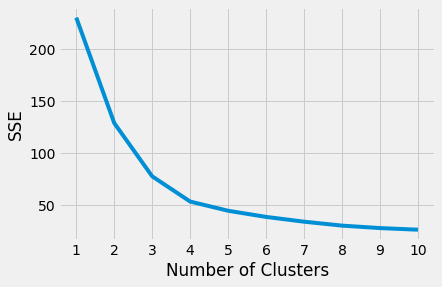

In [66]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [67]:
kl = KneeLocator(
   ...:     range(1, 11), sse, curve="convex", direction="decreasing"
   ...: )
kl.elbow

4

In [68]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scs)
    score = silhouette_score(scs, kmeans.labels_)
    silhouette_coefficients.append(score)

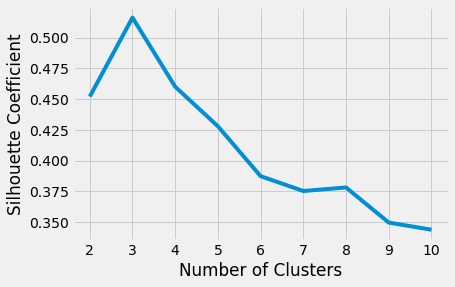

In [69]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### K-Means 3-cluster

In [ ]:
km3 = KMeans(init='k-means++', n_clusters=3)
km3.fit(scs)
y_kmeans3 = km3.predict(scs)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = scs["GnEn"]
y = scs["GnEp"]
z = scs["GpEn"]
c = scs["GpEp"]

img = ax.scatter(x, y, z, c=y_kmeans3, cmap=plt.viridis())
fig.colorbar(img)
plt.show()

### K-Means 4-cluster

In [ ]:
km4 = KMeans(init='k-means++', n_clusters=4)
km4.fit(scs)
y_kmeans4 = km4.predict(scs)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = scs["GnEn"]
y = scs["GnEp"]
z = scs["GpEn"]
#c = scs["GpEp"]

img = ax.scatter(x, y, z, c=y_kmeans4, cmap=plt.viridis())
fig.colorbar(img)
plt.show()

### K-Means 5-cluster

In [ ]:
km5 = KMeans(init='k-means++', n_clusters=5)
km5.fit(scs)
y_kmeans5 = km5.predict(scs)
#k_means = pd.DataFrame(y_kmeans)
#print(k_means.to_string(index=False, header=False))

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = scs["GnEn"]
y = scs["GnEp"]
z = scs["GpEn"]
c = scs["GpEp"]

img = ax.scatter(x, y, z, c=y_kmeans5, cmap=plt.viridis())
fig.colorbar(img)
plt.show()

### Avg Cluster Responses

In [ ]:
#subList = pd.DataFrame(subs, columns=['sub'])
subList = thresh80[["sub"]]
subList = subList.reset_index(drop=True)

In [ ]:
cluster_model3 = pd.DataFrame(y_kmeans3, columns=['clust'])
subClusts3 = pd.concat([subList, cluster_model3], axis=1)
clustList3 = pd.concat([subClusts3, scs], axis=1)
clst3_melt = pd.melt(clustList3,('sub','clust'),var_name='cond',value_name='rating')

In [ ]:
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=4, data=clst3_melt)

In [ ]:
cluster_model4 = pd.DataFrame(y_kmeans4, columns=['clust'])
subClusts4 = pd.concat([subList, cluster_model4], axis=1)
clustList4 = pd.concat([subClusts4, scs], axis=1)
clst4_melt = pd.melt(clustList4,('sub','clust'),var_name='cond',value_name='rating')

In [ ]:
# Plot cluster average responses for 4 conditions
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=4, data=clst4_melt)

In [ ]:
cluster_model5 = pd.DataFrame(y_kmeans5, columns=['clust'])
subClusts5 = pd.concat([subList, cluster_model5], axis=1)
clustList5 = pd.concat([subClusts5, scs], axis=1)
clst5_melt = pd.melt(clustList5,('sub','clust'),var_name='cond',value_name='rating')

In [ ]:
xy = list(y_kmeans5)
len(xy)
#xy

In [ ]:
g = sns.catplot(x="cond", y="rating", kind='bar', col="clust", col_wrap=5, data=clst5_melt)

### K-Means - RMET x cluster

In [ ]:
KM3Clust_RMET = pd.concat([clustList3, rmet], axis=1)
g = sns.catplot(x="clust", y="rmet", kind='bar', data=KM3Clust_RMET)

In [ ]:
KM4Clust_RMET = pd.concat([clustList4, rmet], axis=1)
g = sns.catplot(x="clust", y="rmet", kind='bar', data=KM4Clust_RMET)

In [ ]:
KM5Clust_RMET = pd.concat([clustList5, rmet], axis=1)
#KM5Clust_RMET.to_csv("C:/Users/bbio/Desktop/pilot_data/shortened/5ClustKMeans.csv", index=False)
g = sns.catplot(x="clust", y="rmet", kind='bar', data=KM5Clust_RMET)

In [ ]:
# Rmet arrays by cluster
clust0 = KM5Clust_RMET[KM5Clust_RMET["clust"] == 0]
c0_num = len(clust0)
print("Number of c0 subs: " + str(c0_num))
rc0 = clust0["rmet"]
c0_mean = round(rc0.mean(),2)
print("clust0 mean = " + str(c0_mean))
clust1 = KM5Clust_RMET[KM5Clust_RMET["clust"] == 1]
c1_num = len(clust1)
print("Number of c1 subs: " + str(c1_num))
rc1 = clust1["rmet"]
c1_mean = round(rc1.mean(),2)
print("clust1 mean = " + str(c1_mean))
clust2 = KM5Clust_RMET[KM5Clust_RMET["clust"] == 2]
c2_num = len(clust2)
print("Number of c2 subs: " + str(c2_num))
rc2 = clust2["rmet"]
c2_mean = round(rc2.mean(),2)
print("clust2 mean = " + str(c2_mean))
clust3 = KM5Clust_RMET[KM5Clust_RMET["clust"] == 3]
c3_num = len(clust3)
print("Number of c3 subs: " + str(c3_num))
rc3 = clust3["rmet"]
c3_mean = round(rc3.mean(),2)
print("clust3 mean = " + str(c3_mean))
clust4 = KM5Clust_RMET[KM5Clust_RMET["clust"] == 4]
c4_num = len(clust4)
print("Number of c4 subs: " + str(c4_num))
rc4 = clust4["rmet"]
c4_mean = round(rc4.mean(),2)
print("clust4 mean = " + str(c4_mean))
print("Total # of subs: " + str(sum([c0_num,c1_num,c2_num,c3_num,c4_num])))

In [ ]:
ztest ,pval1 = stests.ztest(rc0, x2=rc4, value=0,alternative='two-sided')
print("Aware Biased vs Indiscriminant")
print(round(pval1,3))

In [ ]:
KM5Clust_RMET.shape

In [ ]:
#statistics.stdev(rc4)

In [ ]:
c0A = clust0[["sub"]]
c0B = clust0[["rmet"]]
c0SR = pd.concat([c0A,c0B],axis=1)
c1A = clust1[["sub"]]
c1B = clust1[["rmet"]]
c1SR = pd.concat([c1A,c1B],axis=1)
c2A = clust2[["sub"]]
c2B = clust3[["rmet"]]
c2SR = pd.concat([c2A,c2B],axis=1)
c3A = clust3[["sub"]]
c3B = clust3[["rmet"]]
c3SR = pd.concat([c3A,c3B],axis=1)
c4A = clust4[["sub"]]
c4B = clust4[["rmet"]]
c4SR = pd.concat([c4A,c4B],axis=1)

In [ ]:
c4SR

In [ ]:
c4SR.mean()

In [ ]:
scs

In [ ]:
KM5Clust_RMET

In [ ]:
clustList5

In [ ]:
fullDF = KM5Clust_RMET

In [ ]:
# Difference sum of squares
vals = pd.DataFrame(columns=['intDiff', 'gazeDiff', 'exprDiff'])
subCount = len(clustList5["sub"])
subList = clustList5["sub"]
clstList = clustList5["clust"]
for s in range(0,subCount):
    clst = clstList[s]
    if clst == 0:
        clstName = "indiscriminate"
    elif clst == 1:
        clstName = "integrator"
    elif clst == 2:
        clstName = "gaze"
    elif clst == 3:
        clstName = "aware-biased"
    elif clst == 4:
        clstName = "expression"
    currSub = subList[s]
    currRow = scs.iloc[s]
    c1 = currRow[0]
    c2 = currRow[1]
    c3 = currRow[2]
    c4 = currRow[3]
    i1 = -1
    i2 = 0
    i3 = 0
    i4 = 1
    g1 = -1
    g2 = -1
    g3 = 1
    g4 = 1
    e1 = -1
    e2 = 1
    e3 = -1
    e4 = 1
    iv1 = (i1-c1)**2
    iv2 = (i2-c2)**2
    iv3 = (i3-c3)**2
    iv4 = (i4-c4)**2
    ivSum = (iv1+iv2+iv3+iv4)
    ivFinal = str(round(ivSum,2))
    #print(currSub)
    #print("Integration score: " + ivFinal)
    gv1 = (g1-c1)**2
    gv2 = (g2-c2)**2
    gv3 = (g3-c3)**2
    gv4 = (g4-c4)**2
    gvSum = (gv1+gv2+gv3+gv4)
    gvFinal = str(round(gvSum,2))
    #print("Gaze score: " + gvFinal)
    ev1 = (e1-c1)**2
    ev2 = (e2-c2)**2
    ev3 = (e3-c3)**2
    ev4 = (e4-c4)**2
    evSum = (ev1+ev2+ev3+ev4)
    evFinal = str(round(evSum,2))
    #print("Expression score: " + evFinal)
    #print("K-means category: " + clstName)
    tVals = [ivFinal,gvFinal,evFinal]
    tVals = pd.DataFrame(tVals).T
    tVals.columns = ['intDiff','gazeDiff','exprDiff']
    vals = pd.concat([vals, tVals])
    vals = vals.reset_index(drop=True)

In [ ]:
vals

In [ ]:
fullDF = pd.concat([fullDF,vals],axis=1)

In [ ]:
fullDF

In [ ]:
c0_fullDF = fullDF[fullDF["clust"] == 0]
c1_fullDF = fullDF[fullDF["clust"] == 1]
c2_fullDF = fullDF[fullDF["clust"] == 2]
c3_fullDF = fullDF[fullDF["clust"] == 3]
c4_fullDF = fullDF[fullDF["clust"] == 4]

In [ ]:
melted_fullDF = pd.melt(fullDF,('sub','clust','GnEn','GnEp','GpEn','GpEp','rmet'),var_name='respType',value_name='val')

In [ ]:
melted_fullDF

In [ ]:
melted_fullDF['val'] = pd.to_numeric(melted_fullDF['val'])

In [ ]:
sns.catplot(x='clust',y='val',hue='respType', kind='bar',data = melted_fullDF, legend_out=True)